In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import sys
sys.path.append('../glac1d_meltwater')
import glac1d_toolbox as tb
import routing as routing
import plotting as plotting

# Demonstration routing algorithm

**Objective** : Transform the routted mask in a spreaded mask by defining zones of 	pickup and distribution of freshwater. Spreading is intended to take a weight off the model as pointlike input of freshwater can break the law of conservation. We also convert and add the waterfix file (to define properly): 
- Collect all the routed meltwater points (m3/s) in collection boxes and distribute them to spread regions overlaped with the 500m land sea mask (m3/s) (conservation of total flux)
- Convert waterfix (kg/m2/s) to (m3/s). Add waterfix file (with nan replaced by 0) (m3/s)
- Check if the spreading worked by performing a flux check

## Inputs

**Routed mask :** 3 dimensional routed poitnlike meltwater mask (routing algorithm outcome). Because the saving algorithm deal with a flux per surface, we also need to convert the meltwater_discharge *(kg/m2/s -> m3/s)*.

In [4]:
ds_routed = xr.open_dataset('/nfs/annie/eeymr/work/outputs/Proj_GLAC1D/dif_-26_0/teadv3.qrparm.GLAC1D_DEGLAC.nc', decode_times=False)
lon_hadcm3, lat_hadcm3, t_hadcm3, discharge = ds_routed.longitude.values, ds_routed.latitude.values, ds_routed.t.values, ds_routed.discharge
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
print(ds_routed)

# TO DO: change convert waterfix to also take into account the discharge.
surface_matrix = tb.surface_matrix(lon_hadcm3, lat_hadcm3)
discharge = np.where(np.isnan(discharge), 0, discharge / 1000 * surface_matrix)

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 261)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600 ... -300 -200 -100 0
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:    waterfix for transient GLAC1D last delgaciation HadCM3 project ...
    history:  Created 2020-02-13 10:11:43.965702 by Yvan Romé


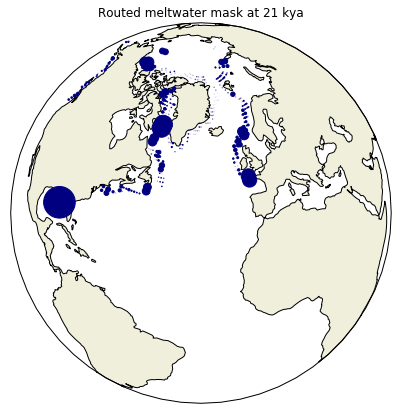

In [10]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

x,y,s = plotting.scatter_mask(discharge[40])
axMap.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title("Routed meltwater mask at 21 kya")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

**Land Sea Mask :** experiment name <-> time table is available on GitHub. Same princiiple than for routing_demo but here we will also use the 500m land sea mask.

Text(0.5,1,'Land sea mask - 500m')

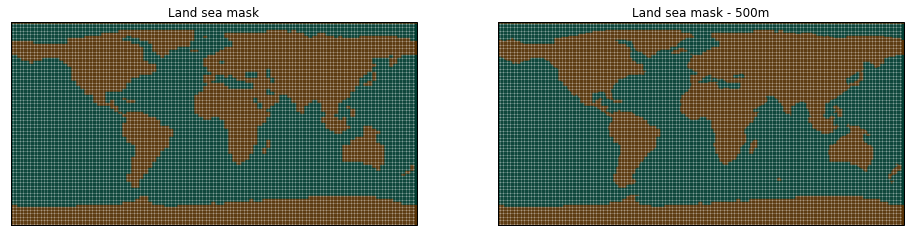

In [8]:
ds_lsm = xr.open_dataset('/nfs/annie/eeymr/work/data/Proj_GLAC1D/lsm/teadv3.qrparm.omask.nc')
lon_lsm, lat_lsm, depth, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.depthdepth.values, ds_lsm.lsm.values

masked = np.copy(lsm)  # land mask True (1) on land
depthm = np.ma.masked_less(depth, 500.0)  # mask areas shallower than 500m
masked_500m = np.copy(depthm.mask) + masked  # create binary mask from depth data

projection_map = ccrs.PlateCarree()

figMap,(axMask, ax500) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))
axMask.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, masked, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMask.set_title("Land sea mask")
ax500.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, masked_500m, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
ax500.set_title("Land sea mask - 500m")